# **Worm tracking with trackpy**

**Ref**
- locate, batch
- link

**Feature finding**
- grey dilation
- find_link

**Coord refinement** *-> centering?*
- refine_com, refine_leastsq

**Linking**
- link_iter, link_df_iter, link_partial

**Static analysis**
- [.static] proximity, pair_correlation_2d, cluster

**Motion analysis**
- [.motion] msd, imsd, emsd, compute_drive, subtract_dirft, vanhove, relate_frames, velocity_corr, direction_corr, it_typicl, diagonal_size, theta_entropy, min_rolling_theta_entropy, filter_stubs, filter_clusters

**Prediction analysis** []

**Plotting tools**
- annotate, scatter, plot_traj, plot_displacements, subpx_bias, plot_density_profile, mass_ecc, mass_size

**Image Conversion**
- find.percentile_threshold
- [.preprocessing] bandpass, lowpass, sclate_to_gamut, invert_image, convert_to_int

## **Load libraries and environment**

In [1]:
import os, sys, copy
sys.path.append('..')

import collections as coll
import itertools as it
import functools as ft

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')
from IPython.display import display

import cv2
import trackpy as tp
from PIL import Image

from src.capture import LazyCapture
from src.labels import load_labels
from src.cleaning import cast, select_channel, plicate_channel, remove_borders, remove_outside_petri
from src.debug import print_frame

## **Auxiliary Functions**

In [2]:
def lowpass(sigma):
    def _inner(i, frame):
        frame = tp.preprocessing.lowpass(frame[:, :, 0], sigma)
        return frame[:, :, np.newaxis]
    return _inner

def bandpass(lshort, llong):
    def _inner(i, frame):
        frame = tp.preprocessing.bandpass(frame[:, :, 0], lshort, llong)
        return frame[:, :, np.newaxis]
    return _inner


"""def coordinate_refinment(f, n, data_frame):
  R = pd.DataFrame()
  for i in range(0, n-1):
    r = tp.refine_com(data_frame[i], data_frame[i], dist_refinment, f[f['frame']==i]) # Check the distance
    r['frame'] = i
    R = pd.concat([R, r])
  return R"""

"def coordinate_refinment(f, n, data_frame):\n  R = pd.DataFrame()\n  for i in range(0, n-1):\n    r = tp.refine_com(data_frame[i], data_frame[i], dist_refinment, f[f['frame']==i]) # Check the distance\n    r['frame'] = i\n    R = pd.concat([R, r])\n  return R"

In [25]:
def average(i, frames):
    frame = frames[0][1][:, :, 0].astype(np.uint32)
    for f in frames[1:]:
        frame += f[1][:, :, 0]
    return (frame / len(frames))[:, :, np.newaxis].astype(np.uint8)

In [4]:
def print_two(first, second):
    ims = [first, second]
    _, ax = plt.subplots(1, 2)
    for i in range(2):
        ax[i].imshow(ims[i], vmin=0, vmax=255)

## **Load Data and Frames**

In [5]:
captures = [
    LazyCapture.load('../data/pw1_A1_0315_part1.avi'),
    LazyCapture.load('../data/pw1_A1_0315_part2.avi'),
    LazyCapture.load('../data/pw1_A1_0315_part3.avi')
]

In [6]:
labels = [
    load_labels('../data/pw1_A1_0315_part1.txt'),
    load_labels('../data/pw1_A1_0315_part2.txt'),
    load_labels('../data/pw1_A1_0315_part3.txt')
]

## **Preprocessing**

In [7]:
for capture in captures:
    w, h = capture.W(), capture.H()
    capture.apply(select_channel(1), shape=(w, h, 1))
    capture.apply(remove_outside_petri((w//2, h//2), (w//2 - 20, h//2 - 20)))
    capture.apply(remove_borders(20, hard=True), shape=(w-40, h-40, 1))

CW, CH = captures[0].W(), captures[0].H()

### Preprocessing testing

In [8]:
# print_frame(True)(fi, f, ((maxs[5][1], maxs[5][0]), maxs[3]))
# cen = pd.DataFrame({"x": maxs[:, 1], "y": maxs[:, 0]})

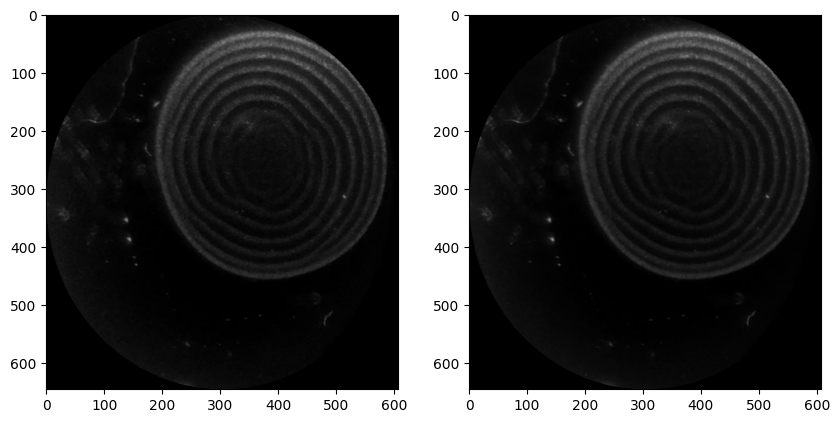

In [32]:
cap_0 = captures[1].clone()
fi1, f1 = cap_0.frame(10, index=False)

cap_0.rolling(average, 3)

fi2, f2 = cap_0.frame(10, index=False)
print_two(f1, f2)

,y,x,mass,size,ecc,signal,raw_mass,ep
70,50.069435,452.952628,607.795200,1.415131,0.150597,56.401501,610.344130,0.0
49,38.036989,414.981830,607.795200,1.429049,0.108736,53.246173,610.008967,0.0
56,41.944056,428.986650,620.416515,1.426076,0.093825,55.218253,622.940790,0.0
145,89.113065,510.849874,627.910421,1.381637,0.135710,63.500991,630.333277,0.0
134,82.915588,503.035120,640.137319,1.421167,0.114418,57.979166,642.196958,0.0
783,314.004393,513.100494,718.231706,1.395647,0.109862,69.811649,721.172073,0.0
288,154.958574,189.921867,752.151490,1.413472,0.117937,69.022816,754.490111,0.0
115,72.994949,491.063131,780.943865,1.433545,0.086397,67.839568,783.819986,0.0
900,354.015291,138.014526,1031.792500,1.420417,0.076696,93.082198,1034.129037,0.0
993,387.932806,143.066834,1097.659988,1.414341,0.091910,100.181688,1099.780875,0.0


/tmp/ipykernel_23726/404930297.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


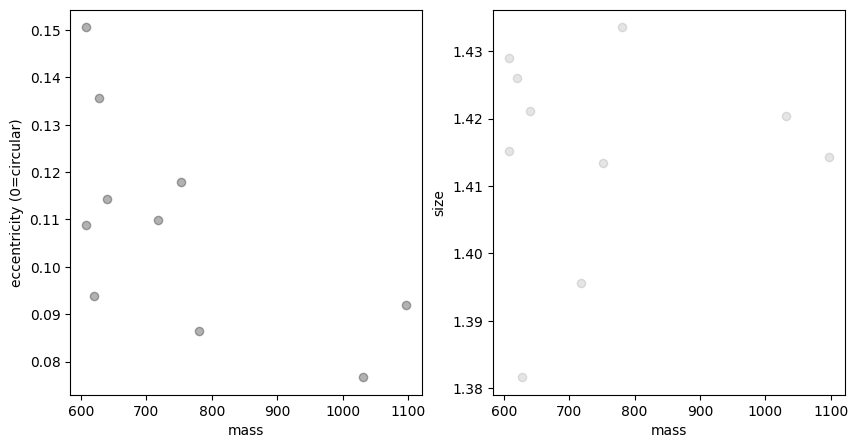

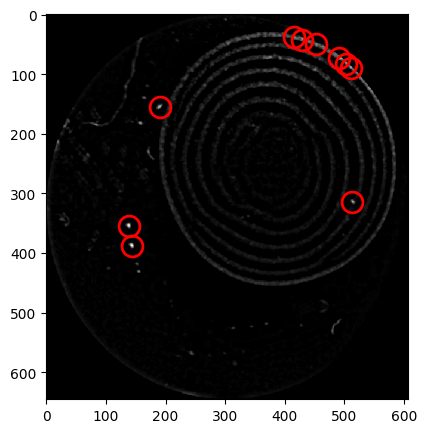

<AxesSubplot: >

In [37]:
cap_1 = captures[1].clone()

cap_1.rolling(average, 3)
cap_1.apply(bandpass(1, 19))

fi, f = cap_1.frame(10, index=False)
ins = (tp.locate(f[:, :, 0], 5,
    minmass=5,
    maxsize=10,
    separation=6,
    noise_size=10,
    smoothing_size=5,
    threshold=1,
    invert=False,
    percentile=0.80,
    topn=10,
    preprocess=False,
    max_iterations=20,
    characterize=True
))

display(ins)

fig, ax = plt.subplots(1, 2)
tp.mass_ecc(ins, ax=ax[0])
tp.mass_size(ins, ax=ax[1])
fig.show()

fig, ax = plt.subplots()
tp.annotate(ins, f[:, :, 0])

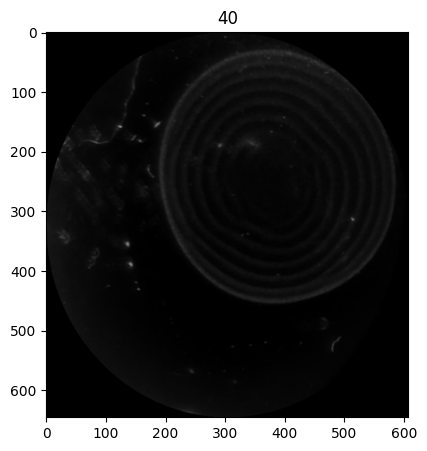

In [38]:
def apply_locate(i, frame):
    locations = (tp.locate(frame[:, :, 0], 5,
    minmass=5,
    maxsize=10,
    separation=6,
    noise_size=10,
    smoothing_size=5,
    threshold=1,
    invert=False,
    percentile=0.80,
    topn=10,
    preprocess=False,
    max_iterations=20,
    characterize=True
    ))

    frame = np.concatenate((frame, frame, frame), axis=2).astype(np.uint8)

    for i, row in locations.iterrows():
        y, x = int(row['x']), int(row['y'])
        frame[x-2:x+2, y-2:y+2] = np.array([0, 255, 0], dtype=np.uint8)

    return frame

cap = captures[0].clone()
cap.rolling(average, 3)
cap.apply(bandpass(1, 19))

fi, f = cap.frame(30, index=False)
print_frame(True)(fi, f, None)

#cap.apply(apply_locate, shape=(cap.W(), cap.H(), 3))
#cap.write('../data/test_1.avi')

In [ ]:
# Convolve with a Gaussian to remove short-wavelength noise. 
# Testing

lp_frame = lowpass((0, 1))(0, captures[2].frame(0, index=False)[1])
print_two(captures[2].frame(0, index=False)[1], lp_frame)

In [ ]:
# Convolve with a Gaussian to remove short-wavelength noise and subtract out long-wavelength variations by subtracting a running average.
# Testing

bp_frame = bandpass(1, 41)(0, captures[2].frame(0, index=False)[1])
print_two(captures[2].frame(0, index=False)[1], bp_frame)

In [ ]:
#Test and write bandpass
#cap = captures[2].clone()
#cap.apply(bandpass(1, 41))
#cap.apply(plicate_channel(3), shape=(CW, CH, 3))
#cap.apply(cast(np.uint8))
#cap.write('../data/test.avi')

## **Exploratory Analysis**

**General**

In [ ]:
caps = [captures[2].clone() for _ in range(2)]

# 1
caps[1].apply(bandpass(1, 41))
caps[1].apply(cast(np.uint8))

print(caps[0])

FRAME = 0

In [ ]:
# Single
locs = [0 for _ in range(len(caps))]

In [ ]:
for i, cap in enumerate(caps):
    frame = cap.frame(FRAME, index=False)[1][:, :, 0]
    locs[i] = tp.locate(frame, 19, invert=False, topn=100, preprocess=True) # <-- CHANGE THIS
    tp.subpx_bias(locs[i]) # Check subpixel accuracy (no dip in the middle)

In [ ]:
for i, cap in enumerate(caps):
    frame = cap.frame(FRAME, index=False)[1][:, :, 0]
    tp.annotate(locs[i], frame)
    tp.scatter(locs[i])
    locs[i].head()

In [ ]:
for i, cap in enumerate(caps):
    # This measures are from the top 100 annotations and the single frame
    
    fig, ax = plt.subplots()
    ax.hist(locs[i]['mass'], bins=50)
    ax.set(xlabel='mass', ylabel='count')

    fig, ax = plt.subplots()
    ax.hist(locs[i]['size'], bins=50)
    ax.set(xlabel='size', ylabel='count')

    fig, ax = plt.subplots()
    ax.hist(locs[i]['ecc'], bins=50)
    ax.set(xlabel='ecc', ylabel='count')

    tp.mass_size(locs[i]) 
    tp.mass_ecc(locs[i])
    locs[i].describe()

In [ ]:
# Batch
batchs = [0 for _ in range(len(caps))]

In [ ]:
for i, cap in enumerate(caps):
    frames = [f[1][:, :, 0] for f in it.islice(cap.frames(), 100)]
    tp.quiet() # Turn off progress reports for best performance
    batchs[i] = tp.batch(frames, 19, invert=False, topn=100, preprocess=True)

In [60]:
for i, cap in enumerate(caps):
    # This measures are from the top 100 annotations and all frames

    fig, ax = plt.subplots()
    ax.hist(batchs[i]['mass'], bins=50)
    ax.set(xlabel='mass', ylabel='count')

    fig, ax = plt.subplots()
    ax.hist(batchs[i]['size'], bins=50)
    ax.set(xlabel='size', ylabel='count')

    fig, ax = plt.subplots()
    ax.hist(batchs[i]['ecc'], bins=50)
    ax.set(xlabel='ecc', ylabel='count')

    tp.mass_size(batchs[i]) 
    tp.mass_ecc(batchs[i])
    batchs[i].describe()

NameError: name 'caps' is not defined

# **Annotation**

In [ ]:
FRAME = 0

batches = [0 for _ in range(len(caps))]

for i, cap in enumerate(caps):
    frames = [f[1][:, :, 0] for f in it.islice(cap.frames(), 100)]
    tp.quiet() # Turn off progress reports for best performance
    batches[i] = tp.batch(frames, 19, invert=False, topn=100, preprocess=True)

### **Locate Features**


In [ ]:
# Annotate single frame
for i, cap in enumerate(caps):
    frame = cap.frame(FRAME, index=False)[1][:, :, 0]
    tp.annotate(batches[i][batches[i]['frame'] == FRAME], frame)
    print(batches[i][batches[i]['frame'] == FRAME].describe())

In [ ]:
# Link frames
links = [0 for _ in range(len(caps))]

for i, cap in enumerate(caps):
    tp.quiet()
    links[i] = tp.link(batchs[i], 19, memory=100)
    
    frame = cap.frame(FRAME, index=False)[1][:, :, 0]
    tp.annotate(links[i][links[i]['frame'] == FRAME], frame)
    tp.scatter(links[i])
    print(links[i].describe())

### **Filter trajectories**

In [ ]:
f1_links = [0 for _ in range(len(caps))]

# First way of filtering
for i, cap in enumerate(caps):

    f1_links[i] = tp.filter_stubs(links[i], 100) 

    print('Before:', links[i]['particle'].nunique())
    print('After:', f1_links[i]['particle'].nunique())

    frame = cap.frame(FRAME, index=False)[1][:, :, 0]
    tp.annotate(f1_links[i][f1_links[i]['frame'] == 0], frame)
    tp.scatter(f1_links[i])
    print(f1_links[i].describe())

In [ ]:
f2_links = [0 for _ in range(len(caps))]

# Second way of filtering
for i, cap in enumerate(caps):

    f2_links[i] = tp.filtering.filter_clusters(links[i], 0.75) # Quantile from which to cut off (mean of the size particle)

    print('Before:', links[i]['particle'].nunique())
    print('After:', f2_links[i]['particle'].nunique())

    frame = cap.frame(FRAME, index=False)[1][:, :, 0]
    tp.annotate(f2_links[i][f2_links[i]['frame'] == 0], frame)
    tp.scatter(f2_links[i])
    print(f2_links[i].describe())

In [ ]:
fc_links = [0 for _ in range(len(caps))]

# Custome filtering (With the data of the exploratory analysis)
for i, cap in enumerate(caps):

    fc_links[i] = f2_links[i][((f2_links[i]['mass'] > 1320.421432) & (f2_links[i]['size'] > 5.071604) & (f2_links[i]['ecc'] < 0.343767))] # Filter by mean or quanil, etc

    frame = cap.frame(FRAME, index=False)[1][:, :, 0]
    tp.annotate(fc_links[i][fc_links[i]['frame'] == 0], frame)
    tp.scatter(fc_links[i])
    print(fc_links[i].describe())

In [ ]:
# Visualize some frames
for i, cap in enumerate(caps):
  for j, frame in it.islice(cap.frames(), 5):
    tp.annotate(fc_links[i][fc_links[i]['frame'] == j], frame)

In [ ]:
ref = [0 for _ in range(len(caps))]

# Coordinate refinment - (test)
for i, cap in enumerate(caps):
  for j, frame in it.islice(cap.frames(), 5):
    r = tp.refine_com(frame, frame, 9, fc_links[i][fc_links[i]['frame'] == j]) # Check the distance
    r['frame'] = j
    ref[i] = pd.concat([ref[i], r])

# Another option if overlapping: tp.trackpy.refine_leastsq()

## **Testing** (NOT TRANSLATED YET)

In [ ]:
# Try different dataframes

tp.quiet()

F_1 = tp.batch(framesV3[:500], mask_size, invert=False, topn=n_annotations, preprocess=True) # All annotations no preprocessing
F_2 = tp.batch(frames_p_V3[:500], mask_size, invert=False, topn=n_annotations, preprocess=True) # All annotations preprocessing

In [ ]:
T_1 = tp.link(F_1, 19, memory=100) # Linking no preprocessing
T_2 = tp.link(F_2, 19, memory=100) # Linking preprocessing

In [ ]:
# Try more filtering methods (Do a custome filtering method!!)

T_3 = tp.filtering.filter_clusters(T_1, 0.5) # Filtering by link no preprocessing
T_4 = tp.filtering.filter_clusters(T_2, 0.5) # Filtering by link preprocessing

T_5 = T_3[T_3.particle == 34] # Closest to initial point no preprocessing (Automate or Threshold of min dist)
T_6 = T_4[T_4.particle == 10] # Closest to initial point preprocessing (Automate or Threshold of min dist)

T_7 = coordinate_refinment(T_3, 500, framesV3) # Coordinate refinment T_3
T_8 = coordinate_refinment(T_4, 500, framesV3) # Coordinate refinment T_4

T_9 = coordinate_refinment(T_5, 500, framesV3) # Coordinate refinment T_5
T_10 = coordinate_refinment(T_6, 500, framesV3) # Coordinate refinment T_6

In [ ]:
# Merge the videos

#with open('/content/drive/MyDrive/Gusano/Output_Video/list_of_videos.txt', 'w') as f:
  #f.write('/content/drive/MyDrive/Gusano/Output_Video/F_1_a.avi')
  #f.write('/content/drive/MyDrive/Gusano/Output_Video/F_1_b.avi')

#ffmpeg -f concat -i mylist.txt -c copy Union.avi # This save the merged video??
#ffmpeg -f concat -safe 0 -i mylist.txt -c copy Union.avi
#ffmpeg -i "concat:/content/drive/MyDrive/Gusano/Output_Video/F_1_a.avi|/content/drive/MyDrive/Gusano/Output_Video/F_1_b.avi" -c copy Union.avi

### Minimum distance to the origin

In [ ]:
# Find the closest trajectory respecting the first position of the worm (manual, automatize)
# Firs we have to create de DataFrames

# Coordinates of the first frame
initial_j, initial_i = labels_3[1] #Grirar

m = T_3[T_3['frame']==0] 

I = []
J = []

for i in range(0, m.shape[0]):
  I.append(initial_i)
  J.append(initial_j)

dist_man = abs((m['x'] - I) + (m['y'] - J)) 

#dist_eucl = (t2['x'] - inicial_i)**2 + (t2['y'] - inicial_j)**2

m['dist'] = dist_man

print(m.dist.describe())

In [ ]:
m = m[m.dist < 5]
m

In [ ]:
tp.annotate(m, framesV3[0])

# **Evaluation** (NOT TRANSLATED YET)

In [ ]:
# Metric for evaluating the results

# Mean distance to the real position (Works just for single tracking)
# Try different distance functions (do they work??)

# No coordinate refinment
print('No coordinate refinment')
print('T_5: ',evaluation_mean_dist(500, T_5, labels_3))
print('T_6: ',evaluation_mean_dist(500, T_6, labels_3))
# Coordinate refinment
print('Coordinate refinment')
print('T_9: ',evaluation_mean_dist_R(500, T_9, labels_3))
print('T_10: ',evaluation_mean_dist_R(500, T_10, labels_3))

IDEAS:
- Composition of both preprocessings
- Do a custom filtering
- Use a prediction function to improve results
- If a frame doesn't have an annotation, compute the middle point of the last frame and the next frame with annotation
- Do the tracking in blocks of a relative small amount of frames (easier to follow?)


TO DO:
- Try and code all the 3 diferent videos
- Merge Videos
- Try different types of filtering (do custome)
- Try full frames
- Find the best parameters (memory, mas_size, survive_frame, movement_frames, refinment distance)
- Automatize the finding of the closest trajectory to the initial point of the worm (decide type of distance)

RECOMENDATIONS:
- In linking and filtering don't be too restrictive for not loosing the worm in a huge number of frames
- Maybe removing the outside_petri is not needed